REVIEWER'S CODE (AVERAGED) REPRODUCING STOCHASTIC SURVIVAL OF THE DENSEST

This R notebook is based on the code written by the anonimous reviewer of the paper "Stochastic survival of the densest and mitochondrial DNA clonal expansion in aging" (PNAS, November 2022, [link](https://www.pnas.org/doi/10.1073/pnas.2122073119)). The code shows that stochastic survival of the densest is observed in model based on the Fisher-Wright model of Statistical Genetics. The system is made up of  two coupled units (with hopping) evolving according to the Wright-Fisher model, with discrete non-overlapping generations and binomial sampling from parental generation and for molecules which hop to a neighbouring unit in each generation. In particular, the notebook reproduces the four subpanels of Fig.1C of the above paper, proving that noise, higher mutant density and spatial structure (with hopping of molecules between units) are necessary and sufficient to observe stochastic survival of the densest. 

The idea of checking if stochastic survival of the densest is reproduced in this setting, that is quite different from the continuous-time Poisson Point Process used in the paper, was given by the anonynous reviewer.  The reviewer also wrote the code modelling the dynamics of the system. We added stochastic averages, estimates of standard error of the mean (plotted as error bars) and the option of decreasing the effective growth rate of mutants, which is equivalent to adding selective elimination of mutants. We also wrapped the code in functions for convenient running and plotting.

In [ ]:
run_model <-function(Nss, control, delta, gamma, selective_elimination) {
  set.seed(42)
  # paremeters
  Nss =Nss
  gen = 100

  c = control
  delta = delta
  gamma = gamma
  eps=selective_elimination #Increase in mutants replication rate

  # define number of replicates to loop and average on
  rep=4000

  # automatically set up initial conditions to make nice plots:
  a1 = 0.83
  a2 = 1/delta*(1-a1)
  a3 = 0.83
  a4 = 1/delta*(1-a3)
  k1 = Nss/10
  # define vector to store heteroplasmy of region 1 across replicates
  # define also vector for squares of heteroplasmy, to be used for standard error of the mean (SEM)

  h1.vec = numeric(gen)
  h1sq.vec=numeric(gen)

  #Wrap dynamics in a loop over replcates
  for (k in 1:rep)
  {
      # set initial conditions for wild-type and mutant numbers in the two subpopulations
      
      w1 = k1*a1
      m1 = k1*a2
      w2 = k1*a3
      m2 = k1*a4
      m1.vec = numeric(gen)
      m2.vec = numeric(gen)
      w1.vec = numeric(gen)
      w2.vec = numeric(gen)
      
      
      for ( i in 1:gen)
      {
      m1.vec[i] = m1
      m2.vec[i] = m2
      w1.vec[i] = w1
      w2.vec[i] = w2

      ne1 = w1 + delta*m1
      ne2 = w2 + delta*m2

      # effective growth rate, switching to discrete time
      r1 = exp(c*(1-ne1/Nss))
      r2 = exp(c*(1-ne2/Nss))

      # Poisson-distributed offspring
      #Mutants can have non-zero selective elimination that decreases their effective growth rate
      w1.rep = rpois(1,w1*r1)
      w2.rep = rpois(1,w2*r2)
      m1.rep = rpois(1,m1*(r1-eps))
      m2.rep = rpois(1,m2*(r2-eps))

      # migration by binomial sampling
      mig.wt.1_2 = rbinom(1,w1.rep,gamma)
      mig.wt.2_1 = rbinom(1,w2.rep,gamma)
      mig.mu.1_2 = rbinom(1,m1.rep,gamma)
      mig.mu.2_1 = rbinom(1,m2.rep,gamma)

      # next generation:
      w1.next = w1.rep + mig.wt.2_1 - mig.wt.1_2
      w2.next = w2.rep + mig.wt.1_2 - mig.wt.2_1
      m1.next = m1.rep + mig.mu.2_1 - mig.mu.1_2
      m2.next = m2.rep + mig.mu.1_2 - mig.mu.2_1

      m1 = m1.next
      m2 = m2.next
      w1 = w1.next
      w2 = w2.next
          
      
      }

  # adding the heteroplasmy of current replicate to vector
  # do the same for squares of heteroplasmy, to estimate SEM
  h1.vec=h1.vec+m1.vec/(m1.vec+w1.vec)  
  h1sq.vec=h1sq.vec+(m1.vec/(m1.vec+w1.vec))**2
  }

  # averaging over replicates
  h1.vec=h1.vec/rep
  #Estimate SEM, to make sure effect is significant
  av_squares      = (h1sq.vec)/rep
  square_averages = (h1.vec)**2
  sample_variance=av_squares-square_averages
  sample_variance <- replace(sample_variance, 1, 0)
  sem=sqrt(sample_variance/rep)

  #For error bars, select every tenth element 
  n_points=gen/10
  sem_short = sem[seq(n_points, length(sem), n_points)]
  h1_short=h1.vec[seq(n_points, length(h1.vec), n_points)]
  x= seq(n_points, gen, by=n_points) 

  initial_value=((m1.vec+m2.vec)/(m1.vec+m2.vec+w1.vec+w2.vec))[1]


  output <-list(h1.vec,initial_value,x,h1_short,sem_short)
  return(output)
}

In [ ]:
run_and_plot <-function(Nss, control, delta, gamma, selective_elimination, color_neutral) {

  output_list=run_model(Nss=Nss, control=control, delta=delta, gamma=gamma, selective_elimination=0)
  h = unlist(output_list[1])
  initial_value = unlist(output_list[2])
  x = unlist(output_list[3])
  h1_short = unlist(output_list[4])
  sem_short= unlist(output_list[5])

  output_list=run_model(Nss=Nss, control=control, delta=delta, gamma=gamma, selective_elimination=selective_elimination)
  h_se = unlist(output_list[1])
  h1_short_se = unlist(output_list[4])
  sem_short_se= unlist(output_list[5])

  lbound=initial_value-0.08
  ubound= initial_value+0.08
  op <- par(cex = 1.5)
  plot(h,lwd=2,type ="l",col=color_neutral,xlab = "Time (generation)",
  ylab = "Mean heteroplasmy", ylim=c(lbound, ubound))
  arrows(x0=x,  y0=h1_short-sem_short, x1=x, y1=h1_short+sem_short, code=3, angle=90, length=0.1, col=color_neutral, lwd=2 )

  lines(h_se,type="l",col="green",lwd=2)
  arrows(x0=x,  y0=h1_short_se-sem_short, x1=x, y1=h1_short_se+sem_short, code=3, angle=90, length=0.1, col="green", lwd=2 )

  abline(h = initial_value,lty=2)
  
  legend("bottomright",  legend = c("Neutral", "Selective elimination"), lty=1, col = c(color_neutral, "green"), box.lty=0)
 
}

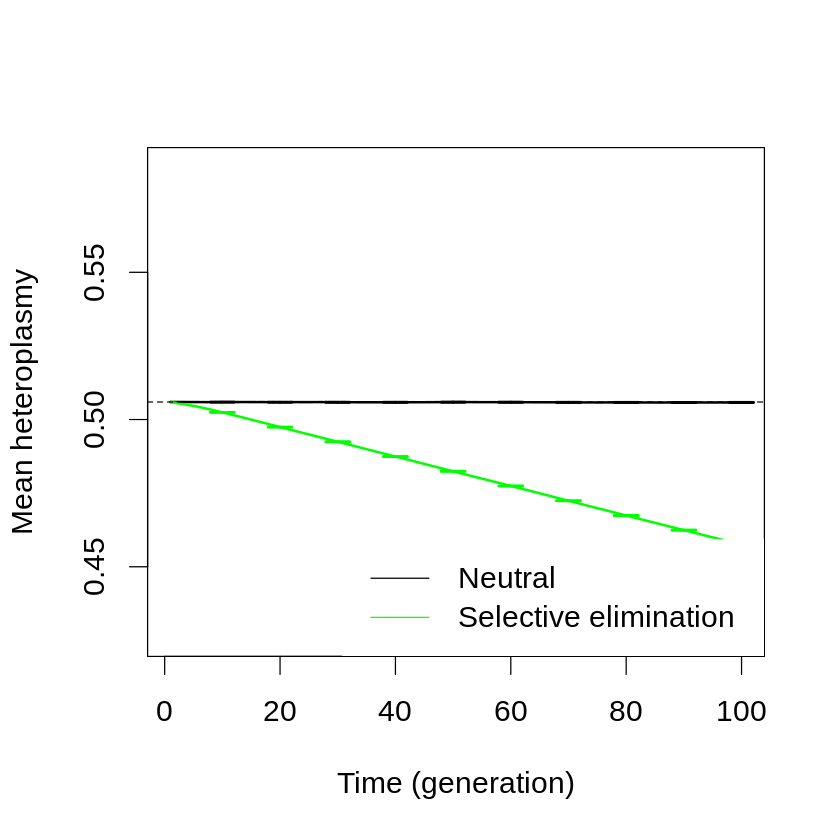

In [ ]:
#DETERMINISTIC LIMIT (Nss --> infinity), mimicking top left subpanel of Fig. 1C.
#Higher mutant density and spatial structure (hopping), but effectively no stochasticity (very large Nss that suppresses fluctuations).
run_and_plot(Nss=500000, control=0.5, delta=0.2, gamma=0, selective_elimination = 0.002, color_neutral="black")


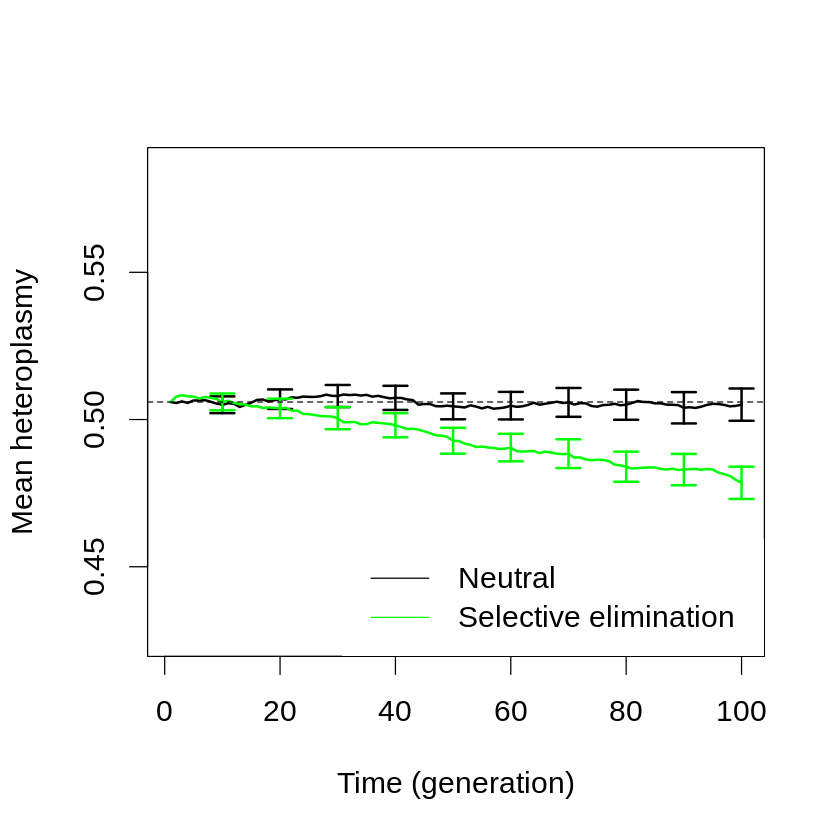

In [ ]:
#Top right subpanel of Fig. 1C
#Noise and higher mutant density, but no spatial structure (i.e., no hopping)
run_and_plot(Nss=100, control=0.5, delta=0.2, gamma=0, selective_elimination = 0.002, color_neutral="black")


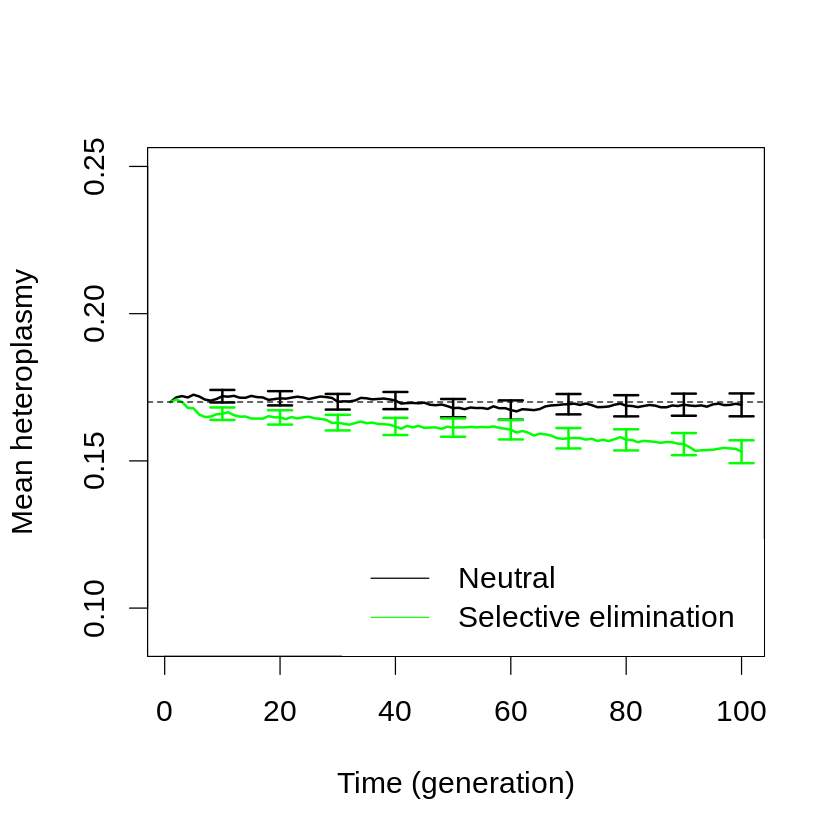

In [ ]:
#Bottom left subpanel of Fig. 1C:
#Noise and spatial structure, but no higher mutant density (delta=1, same density).
run_and_plot(Nss=100, c=0.5, delta=1, gamma=0.1, selective_elimination = 0.002, color_neutral="black")


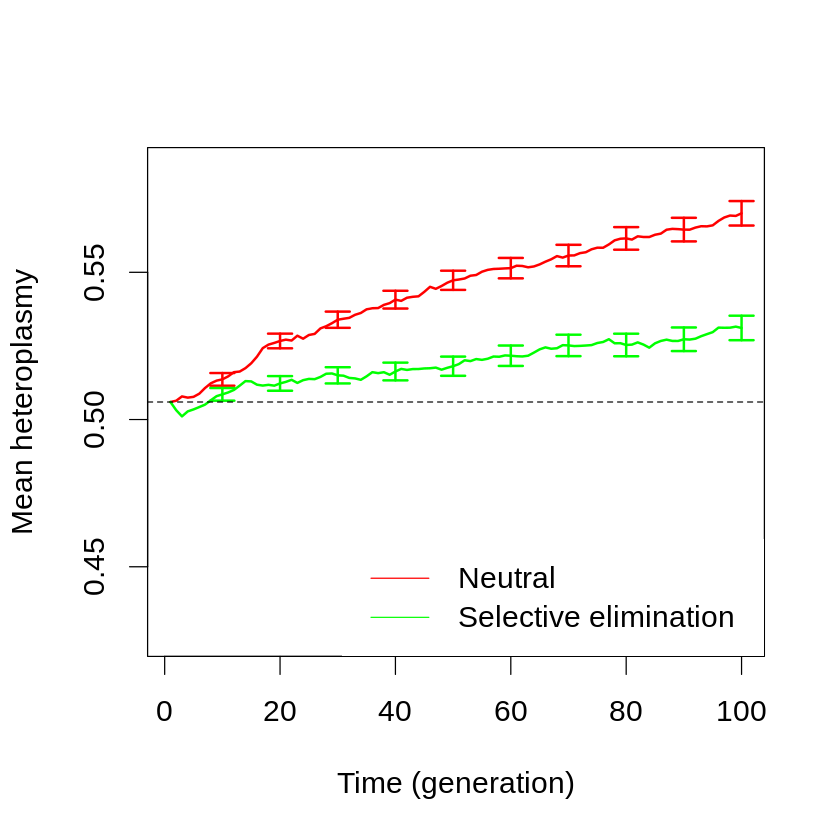

In [ ]:
#Bottom right subpanel of Fig. 1C:
#Noise, density and spatial structure: stochastic survival of the densest.
run_and_plot(Nss=100, c=0.5, delta=0.2, gamma=0.1, selective_elimination = 0.002, color_neutral="red")
